### Imports

In [1]:
from torchvision import datasets
from torchvision import transforms as T
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.models import efficientnet_b1
from sklearn.metrics import accuracy_score
import torch
import os
from tqdm.notebook import tqdm
from torch import nn, optim 
import math
import imgaug.augmenters as iaa
from random import randint, sample

from PIL.Image import fromarray
import cv2
from scipy.spatial.distance import cosine
import pandas as pd
from swin import SwinTransformer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


pwd = os.getcwd()

### Define model

#### Implementation of ArcFace: Additive Angular Margin Loss for Deep Face Recognition
https://arxiv.org/pdf/1801.07698.pdf

In [ ]:
class ArcFace(nn.Module):
     def __init__(self, feat_dim, num_class, margin_arc=0.6, margin_am=0.0, scale=26):
         super(ArcFace, self).__init__()
         self.weight = nn.Parameter(torch.Tensor(feat_dim, num_class))
         self.weight.data.uniform_(-1, 1).renorm_(2, 1, 1e-5).mul_(1e5)
         self.margin_arc = margin_arc
         self.margin_am = margin_am
         self.scale = scale
         self.cos_margin = math.cos(margin_arc)
         self.sin_margin = math.sin(margin_arc)
         self.min_cos_theta = math.cos(math.pi - margin_arc)

     def forward(self, feats, labels):
         kernel_norm = F.normalize(self.weight, dim=0)
         feats = F.normalize(feats)
         cos_theta = torch.mm(feats, kernel_norm) 
         cos_theta = cos_theta.clamp(-1, 1)
         sin_theta = torch.sqrt(1.0 - torch.pow(cos_theta, 2))
         cos_theta_m = cos_theta * self.cos_margin - sin_theta * self.sin_margin
         
         cos_theta_m = torch.where(cos_theta > self.min_cos_theta, cos_theta_m, cos_theta-self.margin_am)
         index = torch.zeros_like(cos_theta)

         index.scatter_(1, labels.data.view(-1, 1), 1)
         index = index.type(torch.bool)
         output = cos_theta * 1.0
         output[index] = cos_theta_m[index]
         output *= self.scale

         return output

### Implementation of AdaCos: Adaptively Scaling Cosine Logits for Effectively Learning Deep Face Representations
https://arxiv.org/pdf/1905.00292.pdf

In [2]:
class AdaCos(nn.Module):
     def __init__(self, feat_dim, num_classes):
         super(AdaCos, self).__init__()
         self.scale = math.sqrt(2) * math.log(num_classes - 1)
         self.W = nn.Parameter(torch.FloatTensor(num_classes, feat_dim))
         nn.init.xavier_uniform_(self.W)
         
     def forward(self, feats, labels):
         W = F.normalize(self.W)

         logits = F.linear(feats, W)

         theta = torch.acos(torch.clamp(logits, -1.0 + 1e-7, 1.0 - 1e-7))
         one_hot = torch.zeros_like(logits)
         one_hot.scatter_(1, labels.view(-1, 1).long(), 1)
        
         with torch.no_grad():
             B_avg = torch.where(one_hot < 1, torch.exp(self.scale * logits), torch.zeros_like(logits))
             B_avg = torch.sum(B_avg) / feats.size(0)
             
             theta_med = torch.median(theta[one_hot == 1])
             self.scale = torch.log(B_avg) / torch.cos(torch.min(math.pi/4 * torch.ones_like(theta_med), theta_med))
             
         output = self.scale * logits
         return output

### Net with Efficient net backbone

In [ ]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
                
        self.backbone = efficientnet_b1(pretrained=False)
        
        self.fc1 = nn.Linear(1000, 840)
        self.bn1 = nn.BatchNorm1d(840)
        
        self.fc2 = nn.Linear(840, 320)

        self.arc_face = AdaCos(320, num_classes)
        
    def forward(self, x, targets = None):
        x = self.backbone(x)

        x = F.relu(self.bn1(self.fc1(x)))
        x = F.normalize(self.fc2(x))
        
        if targets is not None:
            logits = self.arc_face(x, targets)
            return logits

        return x

input_size = (240, 240)


### Net with Swin Transformer S backbone

In [ ]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
                
        self.backbone = SwinTransformer(img_size=224,
                                patch_size=4,
                                in_chans=3,
                                num_classes=num_classes,
                                embed_dim=96,
                                depths= [ 2, 2, 6, 2 ],
                                num_heads= [ 3, 6, 12, 24 ],
                                window_size=7,
                                mlp_ratio=4.,
                                qkv_bias=True,
                                qk_scale=None,
                                drop_rate=0.0,
                                drop_path_rate=0.2,
                                ape=False,
                                patch_norm=True)
        
        self.fc1 = nn.Linear(768, 768)
        self.bn1 = nn.BatchNorm1d(768)
        
        self.fc2 = nn.Linear(768, 256)

        self.arc_face = AdaCos(256, num_classes)
        
    def forward(self, x, targets = None):
        x = self.backbone(x)

        x = F.relu(self.bn1(self.fc1(x)))
        x = F.normalize(self.fc2(x))
        
        if targets is not None:
            logits = self.arc_face(x, targets)
            return logits

        return x

input_size = (224, 224)

In [3]:
# model = Net(num_classes=2380)
# x = torch.randn((2, 3, 224, 224), dtype=torch.float32)
# # y = torch.tensor([0, 2730])
# print(model(x).shape)

### Define trainer class

In [4]:
class Trainer():
    
    def __init__(self, criterion = None, optimizer = None, device = None):
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        
        
    def accuracy(self, logits, labels):
        ps = torch.argmax(logits,dim = 1).detach().cpu().numpy()
        acc = accuracy_score(ps,labels.detach().cpu().numpy())
        return acc

        
    def train_batch_loop(self, model, train_loader, i, save_path=None):
        
        epoch_loss = 0.0
        epoch_acc = 0.0
        pbar_train = tqdm(train_loader, desc="Epoch" + " [TRAIN] " + str(i+1))
        batch_num = len(pbar_train)
        for it, data in enumerate(pbar_train):
            
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            
            logits = model(images, labels)
            loss = self.criterion(logits,labels)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            epoch_loss += loss.item()
            epoch_acc += self.accuracy(logits, labels)
            
            postfix = {'loss' : round(float(epoch_loss/(it+1)), 4), 'acc' : float(epoch_acc/(it+1))}
            pbar_train.set_postfix(postfix)
            
            if save_path is not None:
                if it % 200 == 199:
                    with open(save_path + 'train_log.txt', 'a') as f:
                        f.write(f'B# {it+1}/{batch_num}, Loss: {round(float(epoch_loss/(it+1)), 4)}, Acc: {float(epoch_acc/(it+1))} \n')
                
                if it % 2000 == 1999:
                    torch.save(model, save_path + 'model_.pth')
                
            
        return epoch_loss / len(train_loader), epoch_acc / len(train_loader)
            
    
    def valid_batch_loop(self, model, valid_loader, i, save_path=None):
        
        epoch_loss = 0.0
        epoch_acc = 0.0
        pbar_valid = tqdm(valid_loader, desc = "Epoch" + " [VALID] " + str(i+1))
        batch_num = len(pbar_valid)
        
        for it, data in enumerate(pbar_valid):
            
            images,labels = data
            images = images.to(device)
            labels = labels.to(device)
            
            logits = model(images, labels)
            loss = self.criterion(logits, labels)
            
            epoch_loss += loss.item()
            epoch_acc += self.accuracy(logits, labels)
            
            postfix = {'loss' : round(float(epoch_loss/(it+1)), 4), 'acc' : float(epoch_acc/(it+1))}
            pbar_valid.set_postfix(postfix)
            
            
            if save_path is not None:
                if it % 200 == 199:
                    with open(save_path + 'valid_log.txt', 'a') as f:
                        f.write(f'B # {it+1}/{batch_num}, Loss: {round(float(epoch_loss/(it+1)), 4)}, Acc: {float(epoch_acc/(it+1))} \n')
            
        return epoch_loss / len(valid_loader), epoch_acc / len(valid_loader)
            
    
    def run(self, model, train_loader, valid_loader=None, schedule=None, epochs=1, save_path=None):
        if not os.path.exists(save_path) and save_path is not None:
            os.mkdir(save_path)
        
        if schedule is not None:
            if len(schedule) != epochs:
                raise Exception('Scedule lenght must be equal epoch num')
        
        
        for i in range(epochs):
            if save_path is not None:
                epoch_save_path = save_path + f'epoch_{i}/'
                if not os.path.exists(epoch_save_path):
                    os.mkdir(epoch_save_path)
            else:
                epoch_save_path = None
            
            if schedule is not None:
                for g in self.optimizer.param_groups:
                    g['lr'] = schedule[i]
            
            model.train()
            avg_train_loss, avg_train_acc = self.train_batch_loop(model, train_loader, i, save_path=epoch_save_path)
            
            if save_path is not None:
                torch.save(model, epoch_save_path + 'model.pth')
            
            if valid_loader is not None:
                model.eval()
                avg_valid_loss, avg_valid_acc = self.valid_batch_loop(model, valid_loader, i, save_path=epoch_save_path)
            
        return model
    
    def run_eval(self, model, data_lodaer):
        model.eval()
        avg_valid_loss, avg_valid_acc = self.valid_batch_loop(model, data_lodaer, 0)
        return avg_valid_loss, avg_valid_acc

### Define data set generators

#### Custom data set generator with real-time augmentation

In [6]:
class ImageDataset(Dataset):
  def __init__(self, csv, img_folder, transform=None):
    self.transform = transform
    self.img_folder = img_folder
     
    self.images = csv['img']
    self.targets = csv['Y']
   

  def __len__(self):
    return len(self.images)
 

  def __getitem__(self, index):

    image = cv2.cvtColor(cv2.imread(self.img_folder + self.images[index]), cv2.COLOR_BGR2RGB)
    target = self.targets[index]
     
    if self.transform is not None:
        image = self.transform(image)
    
    return image, target
  

data_dicts = []
for class_n in os.listdir(pwd + '/data/dataset_train/'):
    for img in os.listdir(pwd + '/data/dataset_train/' + class_n):
        data_dicts.append({'img': class_n + '/' + img, 'Y': int(class_n)})

data = pd.DataFrame(data_dicts)

In [ ]:
transforms_list = T.Compose([             
    iaa.Sequential([
        iaa.flip.Fliplr(p=0.5),
        iaa.Sometimes(0.22, iaa.GammaContrast((0.72, 1.29))),
        iaa.Sometimes(0.22, iaa.AddToSaturation((-23, 23))),
        iaa.Sometimes(0.22, iaa.Crop(percent=(0.028, 0.06), keep_size=True)),
        iaa.size.Resize(input_size, interpolation='cubic')
    ]).augment_image,     
    T.ToTensor()
])

train_dataset = ImageDataset(data,
                             pwd + '/data/dataset_train/',
                             transform=transforms_list)

#### Common torch data loader

In [ ]:
transforms_list = T.Compose([T.ToPILImage(),
                            T.Resize((260, 260)),
                             T.ToTensor()])

train_dataset = datasets.ImageFolder(root=pwd + '/data/dataset_train/', transform=transforms_list)


### Train model

#### Set up training params

In [7]:
batch_size = 8
num_epochs = 3
lr = 0.0005
schedule = [0.0005, 0.0002, 0.00008]
num_classes = 2380
save_path = pwd + '/models/swin-s_v1'

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)

### Start training

In [10]:
model = Net(num_classes=num_classes).to(device)
model = torch.load(pwd + '/models/swin-s_v1/epoch_2/model.pth')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

trainer = Trainer(criterion=criterion,
                  optimizer=optimizer,
                  device=device)

In [ ]:
trainer.run(model, train_loader, epochs=num_epochs, save_path=save_path)

In [ ]:
trainer.run_eval(model, train_loader)

### Quick inferrence results

In [11]:
model.eval()
img = cv2.cvtColor(cv2.imread(pwd + 'data/dataset_test/2/91545.jpg'), cv2.COLOR_BGR2RGB)
# img = cv2.imread('/home/NIX/kutsenko-t/metric_learning/dataset_test/22/148849.jpg')
input = cv2.resize(img, (260, 260))
transform = T.ToTensor()
input = torch.unsqueeze(transform(input), 0).to(device)

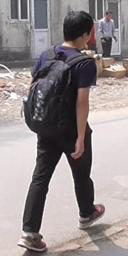

In [12]:
p = model(input).detach().cpu().numpy()
fromarray(img)

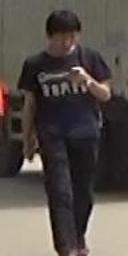

In [51]:
p2 = model(input).detach().cpu().numpy()
fromarray(img)

In [56]:
1 - cosine(p, p2)

0.8691153526306152

### Test set evaluation on 2 randomly selected either from same class or from different one

In [17]:
model.eval()
num_samples = 3000

data_path = pwd + '/data/dataset_test_m/'
all_classes = os.listdir(data_path)


tqdm_wrapper = tqdm(range(num_samples), desc = "Evaluation progress", total=num_samples)
total_correct = 0
false_positive = 0
false_negative = 0

threshold = 0.4

n = 0
for i in tqdm_wrapper:
    is_positive = randint(0, 1)
    
    if is_positive:
        class_1 = sample(all_classes, 1)[0]
        img_1_path, img_2_path = sample(os.listdir(data_path + class_1), 2)
        
        img_1 = cv2.cvtColor(cv2.imread(data_path + class_1 + '/' + img_1_path), cv2.COLOR_BGR2RGB)
        input_1 = torch.unsqueeze(transforms_list(img_1), 0).to(device)
        
        img_2 = cv2.cvtColor(cv2.imread(data_path + class_1 + '/' + img_2_path), cv2.COLOR_BGR2RGB)
        input_2 = torch.unsqueeze(transforms_list(img_2), 0).to(device)
        
        
        embed1 = model(input_1).detach().cpu().numpy()
        embed2 = model(input_2).detach().cpu().numpy()
        
        dst = 1 - cosine(embed1, embed2)
        if dst > threshold:
            total_correct += 1
        else:
            false_negative += 1
        
    else:
        class_1, class_2 = sample(all_classes, 2)
        img_1 = cv2.cvtColor(cv2.imread(data_path + class_1 + '/' + sample(os.listdir(data_path + class_1), 1)[0]), cv2.COLOR_BGR2RGB)
        input_1 = torch.unsqueeze(transforms_list(img_1), 0).to(device)

        img_2 = cv2.cvtColor(cv2.imread(data_path + class_2 + '/' + sample(os.listdir(data_path + class_2), 1)[0]), cv2.COLOR_BGR2RGB)
        input_2 = torch.unsqueeze(transforms_list(img_2), 0).to(device)
    
        embed1 = model(input_1).detach().cpu().numpy()
        embed2 = model(input_2).detach().cpu().numpy()
        
        dst = 1 - cosine(embed1, embed2)
        if dst < threshold:
            total_correct += 1
        else:
            false_positive += 1
    
    postfix = {'acc' : float(total_correct/(n+1))}
    tqdm_wrapper.set_postfix(postfix)
    n += 1


print(f'False positive {false_positive} , False negative: {false_negative}')
print('Accuracy:', 100 - round((false_positive + false_negative) / num_samples * 100, 2))
        

Evaluation progress:   0%|          | 0/3000 [00:00<?, ?it/s]

False positive 43 , False negative: 94
Accuracy: 95.43
